In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
inputs = np.array([
    [0,0,0,0],
    [1,1,1,1],
    [0,1,1,0],
    [1,0,0,1]
]) # Input samples, sample i is inputs[i,:]
targets = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,1,0,0],
    [1,0,0,0]
]) # Corresponding targets, inputs[i,:] has the corresponding target of target[i,:]

In [10]:
# Parameters
N_hidden_layers = 1 # number of hidden layers
N_layers = N_hidden_layers + 2 # i'm adding an extra layer for input and output, hence the +2
N_hidden_neurons = 256 # number of hidden neurons per layer (for simplicity, assume all hidden layers have same # neurons)
N_epochs = 1000 # Train for some number of epochs
learning_rate = 0.1 # A learning rate which seems to work

# An array to store the number of neurons per layer = [input size, N_hidden_neurons, ..., N_hidden_neurons, output size]
input_size = inputs.shape[1]
output_size = targets.shape[1]
N_neurons_perLayer = [input_size] + [N_hidden_neurons for _ in range(N_hidden_layers)] + [output_size]

# For plotting
error_overTime = np.zeros(N_epochs)

In [11]:
# 2D array of neurons representing our network
# Neuron i in layer j is neurons[j][i]
neurons = np.zeros(shape=(N_layers, N_hidden_neurons))
# the input and output layers have less than N_hidden_neurons, but it's easier to keep the matrix square
# so the 2D matrix has more spaces in the first and last rows than it needs, just ignore the left over

# Weights for the network, randomly initialized between -.1 and .1, good to be small and random
weights = np.random.uniform(low=-.1,high=0.1,size=[N_layers-1,N_hidden_neurons,N_hidden_neurons])
# There are weights between each layer of neurons, so a total of N_layers-1
# Assume fully-connected, so there are N_hidden_neurons^2 weights between each layer
# weights[L][i][j] is the weight from neuron i in layer L, to neuron j in layer L+1

# again, the first and last layers don't use all the weights as they have fewer neurons, but 
# keep the matrix rectangular and ignore the left over

In [12]:
# For backpropagation we are going to compute a number of gradients
# taken from video: https://www.youtube.com/watch?v=VCT1N0EsGj0

# dE / dy , the error with respect to the value of a neuron (how the error changes if we change the value of this neuron)
dEdy = np.zeros(shape=(N_layers,N_hidden_neurons))

# dE / dz , the error with respect to the input to a neuron (how the error changes if we change the input to this neuron)
dEdz = np.zeros(shape=(N_layers,N_hidden_neurons))

# dE / dw , the error with respect to a weight (how the error changes if we change the values of this weight)
dEdw = np.zeros(shape=(N_layers,N_hidden_neurons, N_hidden_neurons))

# We first compute dE/dy for neurons in a layer
# Use that to compute dE/dz for their inputs
# Then use that (plus the value of neurons in previous layer) to compute the dE/dw for the weights
# this dE/dw is the called the gradient
# gradient descent is updating our weights in the direction of the gradient to lower the error

In [13]:
# Train
for epoch in range(N_epochs):
    # Take one sample at a time
    for sampleIndex in range(inputs.shape[0]):
        sample = inputs[sampleIndex,:] # Input sample
        target = targets[sampleIndex,:] # What the output should be
        
        # Set the input neurons
        for i in range(inputs.shape[1]):
            neurons[0][i] = sample[i] # Set the neurons to the integers in sample
        
        ########### Forward propagate ######################################################
        for L in range(1, N_layers): # For each layer
            # Computing the value of neurons in layer L
            for i in range(N_neurons_perLayer[L]): # For each neuron in that layer
                z = 0 # Start at 0
                # Compute the weighted sum of neurons in previous layer to this neuron
                for j in range(N_neurons_perLayer[L-1]): # For each neuron in previous layer
                    n = neurons[L-1][j] # Neuron in previous layer
                    w = weights[L-1][j][i] # Weight from previous layer, neuron j, to this neuron i
                    z += n * w
                # After completing weight sum, do non-linear activation
                value = 1 / ( 1 + np.exp(-z)) # take the sigmoid function of the sum
                neurons[L][i] = value # Done computing this neuron, save it
        ########### End Forward propagate ######################################################
        
        
        ########### Back propagate ######################################################
                
        # Now that forward propagation is done, the output neurons are supposed to be close to the target
        # Start by finding the error, the difference between target and the value of the neurons
        # Generally, y is going to correspond to the value of a neuron, t is the target for a single neuron
        # We define the error as the squared error
        # E = 1/2 * (t - y)^2
        # The value of this function is it has a nice derivative
        # dE/dy = -(t - y)
        # And this is where we start getting our gradients that we can use to update the weights
        
        # Compute dE/dy for the output layer
        outputLayer = N_layers-1
        for i in range(output_size): 
            y = neurons[outputLayer][i] # value of this output neuron
            dEdy[outputLayer][i] = -(target[i] - y) 
            
        # Each neuron has a dE/dy, now we can use its own value to compute its dE/dz 
        for i in range(output_size):  
            # since y (the value of a neuron) is computed as a sigmoid
            # it's derivative with respect to its input z (the weighted sum)
            # is y*(1-y) 
            # because if f(x) = sigmoid(x)
            # df(x)/dx = f(x)*(1-f(x)) by definition
            
            # Value of neuron
            y = neurons[outputLayer][i]
            # dy/dz of the neuron
            dydz = y*(1-y)
            # dE/dz = dy/dz*dE/dy
            dEdz[outputLayer][i] = dydz * dEdy[outputLayer][i]
            
        # Now, we have dE/dz for the output layer
        # We can work backwards through the network, computing gradients based on these gradients
        for L in range(N_layers-2,-1,-1): # Start at 2nd last and go back to 0 (the input layer)
            # For each neuron in this layer
            for i in range(N_neurons_perLayer[L]): # neuron i of this layer L
                # We know the dE/dz for the following (next) layer 
                # That is the  gradient of error for the inputs to those neurons
                # We can now compute the dE/dy for THESE neurons, since we know how they impact the next neurons
                # dE/dy =  SUM (w*dE/dz)
                # the dE/dy of neuron in this layer, is the sum of its weights to neurons in the next layer
                # times their dE/dz
                # intuition: How the value of this neuron affects the error
                # is how it impacts the error on the input to the next layer
                s = 0 # The sum
                # For each neuron in NEXT layer
                for j in range(N_neurons_perLayer[L+1]):
                    w = weights[L][i][j] # The weight from this neuron to neuron j in next layer
                    s += w * dEdz[L+1][j] # dE/dz of neuron j in next layer
                dEdy[L][i] = s # The sum of all its weights times dE/dzs of next layer
                # We can also immediately compute its own dE/dz by rule previously mentioned
                y = neurons[L][i]
                dEdz[L][i] = y*(1-y)*dEdy[L][i] # it's based on its own dE/dy
                
                # Where it all comes together, this is where the weight gradients can be computed
                # Now that we have dE/dz for neurons in THIS layer, we can compute the gradients
                # of the weights leaving it
                # For each neuron in NEXT layer
                for j in range(N_neurons_perLayer[L+1]):
                    # neuron i of this layer, neuron j of next layer
                    # We need the gradient for weight (w) from this neuron i to neuron j in next layer
                    # We already know dE/dz of the next layer, because we computed that earlier
                    # We have the formula
                    # dE/w = dz/dw*dE/dz 
                    # The gradient of this weight, is how z (input of next layer) changes with respect to this weight
                    # times dE/dz (the gradient of the input to neuron j in next layer, which is already computed)
                    # so dz/dw is the only unknown, how the input of next layer neuron j changes with this weight
                    # but we DO know
                    # The input to neuron j (z) is a weighted sum of neurons times weights
                    # So how that input changes with respect to this weight, is the value of this neuron i
                    # because neuron i times this weight goes into neuron j's input
                    # so dz/dw = y , simply the value of this neuron
                    y = neurons[L][i] # This neuron i's value
                    dEdw[L][i][j] = y * dEdz[L+1][j]
                    # This weights gradient, layer L neuron i to layer L+1 neuron j
                    # is the value of neuron i, times dE/dz of neuron j
                    
        ########### End Back propagate ######################################################
        
        ########### Update weights ######################################################
        # Now forward and back propagation is done  
        # We have computed the gradients for all the weights
        # Now we can update (doing batch size = 1, update gradients after every input)
        for L in range(N_layers-1):
            for i in range(N_neurons_perLayer[L]):
                for j in range(N_neurons_perLayer[L+1]):
                    weights[L][i][j] -= learning_rate * dEdw[L][i][j]
                    # For all weights, subtract the gradient times a learning rate
                    # Go in the direction (up or down) such that the error is more negative
        ########### End update weights ######################################################
                    
                
    ############## Extra, compute the error after every epoch
    # After each epoch, test the total error
    total_error = 0
    es = [0,0,0,0]
    for sampleIndex in range(inputs.shape[0]):
        sample = inputs[sampleIndex,:] # Input sample
        target = targets[sampleIndex,:] # What the output should be        
        # Set the input neurons
        for i in range(inputs.shape[1]):
            neurons[0][i] = sample[i] # Set the neurons to the integers in sample      
        ########### Forward propagate ######################################################
        for L in range(1, N_layers): # For each layer
            # Computing the value of neurons in layer L
            for i in range(N_neurons_perLayer[L]): # For each neuron in that layer
                z = 0 # Start at 0
                # Compute the weighted sum of neurons in previous layer to this neuron
                for j in range(N_neurons_perLayer[L-1]): # For each neuron in previous layer
                    n = neurons[L-1][j] # Neuron in previous layer
                    w = weights[L-1][j][i] # Weight from previous layer, neuron j, to this neuron i
                    z += n * w
                # After completing weight sum, do non-linear activation
                value = 1 / ( 1 + np.exp(-z)) # take the sigmoid function of the sum
                neurons[L][i] = value # Done computing this neuron, save it
        ########### End Forward propagate ######################################################
        # Report the error so we can see if it's improving
        serror = 0
        for i in range(output_size):
            serror += 1/2* (target[i]-neurons[N_layers-1][i])**2
        total_error += serror
        es[sampleIndex] = serror
         
    error_overTime[epoch] = total_error

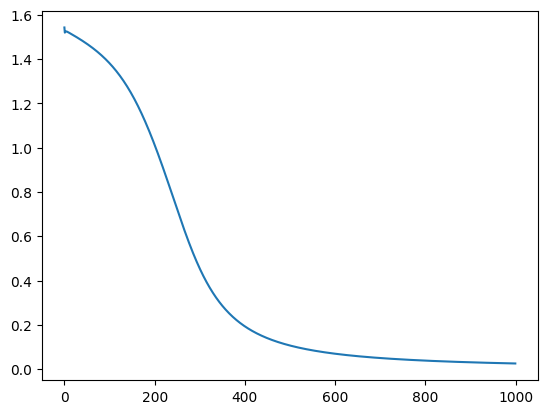

In [14]:
# Plot error during training
plt.plot(range(N_epochs),error_overTime)